## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os
from datasets import load_dataset
import pandas as pd
from PIL import Image

c:\Users\solit\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
class MLP(nn.Module):
    def __init__(self, image_size, num_layers, hidden_channels, num_classes=100):
        super(MLP, self).__init__()
        self.in_channels = image_size * image_size * 3
        self.flatten = nn.Flatten()
        self.layers = self.make_layer(num_classes, num_layers, hidden_channels)


    def make_layer(self, out_channels, num_layers, hidden_channels):
        layers = []
        for idx in range(num_layers):
            layers.extend([nn.Linear(self.in_channels, hidden_channels[idx]),
                           nn.ReLU(inplace=True)])
            self.in_channels = hidden_channels[idx]
            layers.append(nn.Dropout(0.5))
        layers.append(nn.Linear(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [3]:
model = MLP(64, 3, [256, 512, 256])
torchsummary.summary(model)
x = torch.randn(5, 3, 64, 64)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       3,145,984
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       131,584
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       131,328
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      25,700
Total params: 3,434,596
Trainable params: 3,434,596
Non-trainable params: 0


torch.Size([5, 100])

## TinyImageNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [5]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'train')
        self.classes = sorted(os.listdir(self.image_dir))
        self.images = []
        self.labels = []

        if split == 'train':
            for label_idx, class_dir in enumerate(self.classes):
                class_images = os.listdir(os.path.join(self.image_dir, class_dir, 'images'))
                for img_name in class_images:
                    img_path = os.path.join(self.image_dir, class_dir, 'images', img_name)
                    if self.is_rgb(img_path):
                        self.images.append(os.path.join(class_dir, 'images', img_name))
                        self.labels.append(label_idx)

        elif split == 'val':
            self.image_dir = os.path.join(root_dir, 'val', 'images')
            self.annotations_file = os.path.join(root_dir, 'val', 'val_annotations.txt')
            annotations = pd.read_csv(self.annotations_file, sep='\t', header=None)
            for img_name, label in zip(annotations[0], annotations[1]):
                img_path = os.path.join(self.image_dir, img_name)
                if self.is_rgb(img_path):
                    self.images.append(img_name)
                    self.labels.append(self.classes.index(label))

    def is_rgb(self, img_path):
        with Image.open(img_path) as img:
            return img.mode == 'RGB'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4),  
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='train', transform=transform_train)
testset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='val', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


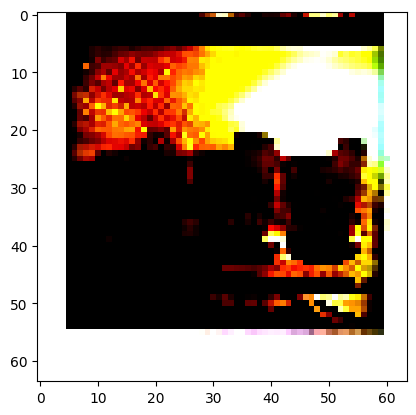

In [7]:
image = testset[2][0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [8]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(testset.classes)}')

Size: (64, 64, 3)
Train: 98179
Test: 9832
Classes: 200


### Config

In [9]:
checkpoint_id = 1
folder_path = f'./MLP/TinyImageNet/checkpoint{checkpoint_id}/'
image_size = 64
num_layers = 3
hidden_channels = [256, 512, 256]
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "image_size": image_size,
    "num_layers": num_layers,
    "hidden_channels": hidden_channels,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [10]:
model = MLP(image_size, num_layers, hidden_channels, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader), epochs=num_epochs)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=200, bias=True)
  )
)


### Train, test

In [11]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

  1%|          | 1/100 [01:06<1:49:35, 66.42s/it]

Epoch [1/100], Loss: 5.2970


  2%|▏         | 2/100 [02:11<1:47:08, 65.59s/it]

Epoch [2/100], Loss: 5.2430


  3%|▎         | 3/100 [03:16<1:45:20, 65.16s/it]

Epoch [3/100], Loss: 5.1693


  4%|▍         | 4/100 [04:20<1:43:47, 64.87s/it]

Epoch [4/100], Loss: 5.1146


  5%|▌         | 5/100 [05:25<1:42:36, 64.81s/it]

Epoch [5/100], Loss: 5.0665


  6%|▌         | 6/100 [06:29<1:41:27, 64.76s/it]

Epoch [6/100], Loss: 5.0257


  7%|▋         | 7/100 [07:34<1:40:25, 64.79s/it]

Epoch [7/100], Loss: 4.9993


  8%|▊         | 8/100 [08:39<1:39:25, 64.84s/it]

Epoch [8/100], Loss: 4.9672


  9%|▉         | 9/100 [09:44<1:38:24, 64.88s/it]

Epoch [9/100], Loss: 4.9430


 10%|█         | 10/100 [10:49<1:37:07, 64.75s/it]

Epoch [10/100], Loss: 4.9298


 11%|█         | 11/100 [11:54<1:36:33, 65.09s/it]

Epoch [11/100], Loss: 4.9105


 12%|█▏        | 12/100 [12:59<1:35:15, 64.94s/it]

Epoch [12/100], Loss: 4.8940


 13%|█▎        | 13/100 [14:04<1:34:16, 65.02s/it]

Epoch [13/100], Loss: 4.8749


 14%|█▍        | 14/100 [15:09<1:32:54, 64.83s/it]

Epoch [14/100], Loss: 4.8580


 15%|█▌        | 15/100 [16:13<1:31:41, 64.73s/it]

Epoch [15/100], Loss: 4.8452


 16%|█▌        | 16/100 [17:18<1:30:28, 64.63s/it]

Epoch [16/100], Loss: 4.8321


 17%|█▋        | 17/100 [18:22<1:29:13, 64.50s/it]

Epoch [17/100], Loss: 4.8239


 18%|█▊        | 18/100 [19:26<1:28:06, 64.47s/it]

Epoch [18/100], Loss: 4.8139


 19%|█▉        | 19/100 [20:31<1:27:05, 64.51s/it]

Epoch [19/100], Loss: 4.7992


 20%|██        | 20/100 [21:35<1:26:02, 64.53s/it]

Epoch [20/100], Loss: 4.7915


 21%|██        | 21/100 [22:40<1:24:57, 64.53s/it]

Epoch [21/100], Loss: 4.7774


 22%|██▏       | 22/100 [23:45<1:24:00, 64.62s/it]

Epoch [22/100], Loss: 4.7694


 23%|██▎       | 23/100 [24:49<1:22:44, 64.47s/it]

Epoch [23/100], Loss: 4.7594


 24%|██▍       | 24/100 [25:53<1:21:34, 64.40s/it]

Epoch [24/100], Loss: 4.7485


 25%|██▌       | 25/100 [26:57<1:20:29, 64.39s/it]

Epoch [25/100], Loss: 4.7433


 26%|██▌       | 26/100 [28:02<1:19:38, 64.58s/it]

Epoch [26/100], Loss: 4.7337


 27%|██▋       | 27/100 [29:07<1:18:38, 64.64s/it]

Epoch [27/100], Loss: 4.7215


 28%|██▊       | 28/100 [30:12<1:17:31, 64.60s/it]

Epoch [28/100], Loss: 4.7155


 29%|██▉       | 29/100 [31:17<1:16:43, 64.84s/it]

Epoch [29/100], Loss: 4.7050


 30%|███       | 30/100 [32:21<1:15:27, 64.68s/it]

Epoch [30/100], Loss: 4.7019


 31%|███       | 31/100 [33:26<1:14:19, 64.64s/it]

Epoch [31/100], Loss: 4.6912


 32%|███▏      | 32/100 [34:30<1:13:02, 64.44s/it]

Epoch [32/100], Loss: 4.6834


 33%|███▎      | 33/100 [35:35<1:12:10, 64.64s/it]

Epoch [33/100], Loss: 4.6746


 34%|███▍      | 34/100 [36:41<1:11:26, 64.95s/it]

Epoch [34/100], Loss: 4.6677


 35%|███▌      | 35/100 [37:45<1:10:16, 64.87s/it]

Epoch [35/100], Loss: 4.6629


 36%|███▌      | 36/100 [38:50<1:08:57, 64.64s/it]

Epoch [36/100], Loss: 4.6562


 37%|███▋      | 37/100 [39:53<1:07:33, 64.34s/it]

Epoch [37/100], Loss: 4.6509


 38%|███▊      | 38/100 [40:59<1:06:50, 64.68s/it]

Epoch [38/100], Loss: 4.6449


 39%|███▉      | 39/100 [42:03<1:05:48, 64.73s/it]

Epoch [39/100], Loss: 4.6414


 40%|████      | 40/100 [43:08<1:04:48, 64.81s/it]

Epoch [40/100], Loss: 4.6310


 41%|████      | 41/100 [44:12<1:03:14, 64.31s/it]

Epoch [41/100], Loss: 4.6265


 42%|████▏     | 42/100 [45:14<1:01:42, 63.83s/it]

Epoch [42/100], Loss: 4.6201


 43%|████▎     | 43/100 [46:17<1:00:19, 63.50s/it]

Epoch [43/100], Loss: 4.6169


 44%|████▍     | 44/100 [47:20<59:02, 63.26s/it]  

Epoch [44/100], Loss: 4.6099


 45%|████▌     | 45/100 [48:23<57:52, 63.14s/it]

Epoch [45/100], Loss: 4.6032


 46%|████▌     | 46/100 [49:25<56:44, 63.04s/it]

Epoch [46/100], Loss: 4.5995


 47%|████▋     | 47/100 [50:30<56:06, 63.52s/it]

Epoch [47/100], Loss: 4.5939


 48%|████▊     | 48/100 [51:35<55:18, 63.82s/it]

Epoch [48/100], Loss: 4.5901


 49%|████▉     | 49/100 [52:39<54:24, 64.01s/it]

Epoch [49/100], Loss: 4.5859


 50%|█████     | 50/100 [53:44<53:28, 64.17s/it]

Epoch [50/100], Loss: 4.5792


 51%|█████     | 51/100 [54:48<52:30, 64.30s/it]

Epoch [51/100], Loss: 4.5774


 52%|█████▏    | 52/100 [55:53<51:30, 64.39s/it]

Epoch [52/100], Loss: 4.5743


 53%|█████▎    | 53/100 [56:57<50:26, 64.40s/it]

Epoch [53/100], Loss: 4.5634


 54%|█████▍    | 54/100 [58:01<49:19, 64.33s/it]

Epoch [54/100], Loss: 4.5641


 55%|█████▌    | 55/100 [59:06<48:12, 64.28s/it]

Epoch [55/100], Loss: 4.5589


 56%|█████▌    | 56/100 [1:00:11<47:29, 64.76s/it]

Epoch [56/100], Loss: 4.5544


 57%|█████▋    | 57/100 [1:01:17<46:40, 65.13s/it]

Epoch [57/100], Loss: 4.5527


 58%|█████▊    | 58/100 [1:02:22<45:30, 65.01s/it]

Epoch [58/100], Loss: 4.5481


 59%|█████▉    | 59/100 [1:03:27<44:21, 64.91s/it]

Epoch [59/100], Loss: 4.5479


 60%|██████    | 60/100 [1:04:31<43:09, 64.74s/it]

Epoch [60/100], Loss: 4.5389


 61%|██████    | 61/100 [1:05:36<42:02, 64.68s/it]

Epoch [61/100], Loss: 4.5364


 62%|██████▏   | 62/100 [1:06:40<40:57, 64.66s/it]

Epoch [62/100], Loss: 4.5358


 63%|██████▎   | 63/100 [1:07:45<39:51, 64.64s/it]

Epoch [63/100], Loss: 4.5291


 64%|██████▍   | 64/100 [1:08:49<38:45, 64.59s/it]

Epoch [64/100], Loss: 4.5280


 65%|██████▌   | 65/100 [1:09:54<37:40, 64.58s/it]

Epoch [65/100], Loss: 4.5213


 66%|██████▌   | 66/100 [1:10:58<36:34, 64.55s/it]

Epoch [66/100], Loss: 4.5208


 67%|██████▋   | 67/100 [1:12:05<35:47, 65.06s/it]

Epoch [67/100], Loss: 4.5172


 68%|██████▊   | 68/100 [1:13:10<34:44, 65.13s/it]

Epoch [68/100], Loss: 4.5113


 69%|██████▉   | 69/100 [1:14:16<33:43, 65.26s/it]

Epoch [69/100], Loss: 4.5084


 70%|███████   | 70/100 [1:15:21<32:41, 65.37s/it]

Epoch [70/100], Loss: 4.5078


 71%|███████   | 71/100 [1:16:27<31:36, 65.41s/it]

Epoch [71/100], Loss: 4.5011


 72%|███████▏  | 72/100 [1:17:32<30:28, 65.29s/it]

Epoch [72/100], Loss: 4.5032


 73%|███████▎  | 73/100 [1:18:37<29:20, 65.20s/it]

Epoch [73/100], Loss: 4.4996


 74%|███████▍  | 74/100 [1:19:41<28:11, 65.04s/it]

Epoch [74/100], Loss: 4.4961


 75%|███████▌  | 75/100 [1:20:46<27:03, 64.92s/it]

Epoch [75/100], Loss: 4.4948


 76%|███████▌  | 76/100 [1:21:51<25:56, 64.85s/it]

Epoch [76/100], Loss: 4.4916


 77%|███████▋  | 77/100 [1:22:55<24:50, 64.82s/it]

Epoch [77/100], Loss: 4.4881


 78%|███████▊  | 78/100 [1:24:00<23:46, 64.83s/it]

Epoch [78/100], Loss: 4.4883


 79%|███████▉  | 79/100 [1:25:05<22:40, 64.78s/it]

Epoch [79/100], Loss: 4.4839


 80%|████████  | 80/100 [1:26:09<21:32, 64.64s/it]

Epoch [80/100], Loss: 4.4784


 81%|████████  | 81/100 [1:27:14<20:29, 64.73s/it]

Epoch [81/100], Loss: 4.4753


 82%|████████▏ | 82/100 [1:28:19<19:24, 64.69s/it]

Epoch [82/100], Loss: 4.4749


 83%|████████▎ | 83/100 [1:29:23<18:19, 64.67s/it]

Epoch [83/100], Loss: 4.4752


 84%|████████▍ | 84/100 [1:30:28<17:14, 64.68s/it]

Epoch [84/100], Loss: 4.4684


 85%|████████▌ | 85/100 [1:31:33<16:09, 64.64s/it]

Epoch [85/100], Loss: 4.4654


 86%|████████▌ | 86/100 [1:32:38<15:08, 64.88s/it]

Epoch [86/100], Loss: 4.4666


 87%|████████▋ | 87/100 [1:33:43<14:02, 64.82s/it]

Epoch [87/100], Loss: 4.4636


 88%|████████▊ | 88/100 [1:34:48<12:57, 64.81s/it]

Epoch [88/100], Loss: 4.4610


 89%|████████▉ | 89/100 [1:35:52<11:52, 64.78s/it]

Epoch [89/100], Loss: 4.4605


 90%|█████████ | 90/100 [1:36:57<10:47, 64.78s/it]

Epoch [90/100], Loss: 4.4540


 91%|█████████ | 91/100 [1:38:02<09:43, 64.85s/it]

Epoch [91/100], Loss: 4.4551


 92%|█████████▏| 92/100 [1:39:05<08:35, 64.38s/it]

Epoch [92/100], Loss: 4.4509


 93%|█████████▎| 93/100 [1:40:10<07:30, 64.42s/it]

Epoch [93/100], Loss: 4.4522


 94%|█████████▍| 94/100 [1:41:14<06:25, 64.25s/it]

Epoch [94/100], Loss: 4.4464


 95%|█████████▌| 95/100 [1:42:17<05:20, 64.02s/it]

Epoch [95/100], Loss: 4.4438


 96%|█████████▌| 96/100 [1:43:22<04:17, 64.31s/it]

Epoch [96/100], Loss: 4.4445


 97%|█████████▋| 97/100 [1:44:26<03:12, 64.14s/it]

Epoch [97/100], Loss: 4.4404


 98%|█████████▊| 98/100 [1:45:29<02:07, 63.78s/it]

Epoch [98/100], Loss: 4.4387


 99%|█████████▉| 99/100 [1:46:33<01:03, 63.77s/it]

Epoch [99/100], Loss: 4.4394


100%|██████████| 100/100 [1:47:36<00:00, 64.56s/it]

Epoch [100/100], Loss: 4.4371


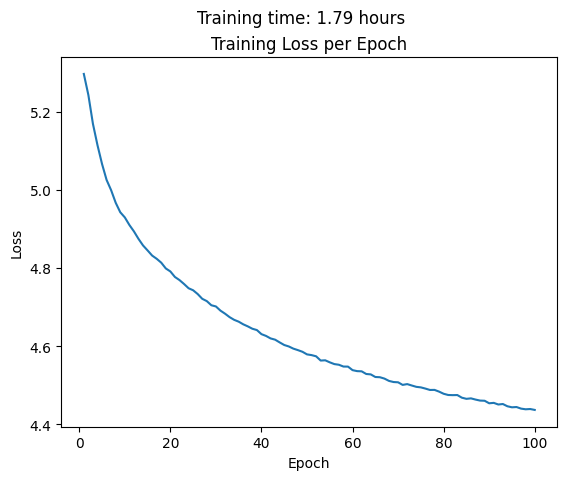

In [12]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [13]:
evaluate(model, testloader, device, folder_path)

Accuracy: 10.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.48      0.35        50
           1       0.06      0.02      0.03        50
           2       0.07      0.04      0.05        50
           3       0.00      0.00      0.00        50
           4       0.24      0.08      0.12        49
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        50
           7       0.00      0.00      0.00        50
           8       0.14      0.06      0.08        50
           9       0.05      0.02      0.03        50
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        50
          13       0.18      0.62      0.28        50
          14       0.19      0.16      0.17        50
          15       0.00      0.00      0.00        49
          16       0.00      0.00      0.

C:\Users\solit\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\solit\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\solit\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i